In [1]:
import utils
from transformers import AutoTokenizer, TFAutoModelForCausalLM
from rouge_score import rouge_scorer, scoring
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model, load_model
import pandas as pd
import os


c:\Users\alecc\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setup ROUGE scorer and tokenizer
ROUGE_METRICS = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
scorer = rouge_scorer.RougeScorer(ROUGE_METRICS, use_stemmer=True)

# Load trained transformer model
tf_model = TFAutoModelForCausalLM.from_pretrained('../trained_models/gpt2-summarization/')
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Constants
TLDR = ' TL;DR '
MAX_LEN = 512

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ../trained_models/gpt2-summarization/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [15]:
ah = {} # GET TESTING HEADLINES FOR EACH DATASET
ph = {} # GET TF PREDICTED HEADLINES FOR EACH DATASET

def summarize_article_tf(model, article):
    tokenized = tokenizer(article, return_tensors="np")
    outputs = model.generate(**tokenized, max_new_tokens=32, pad_token_id=50256)
    return tokenizer.decode(outputs[0])

if 'tf_results.csv' in os.listdir('../data/'):
    preds_df = pd.read_csv('../data/tf_results.csv')
    preds = {'predicted headline': preds_df['predicted headline'].tolist(), 'actual headline': preds_df['actual headline'].tolist()}
else:
    preds = {'predicted headline': [], 'actual headline': []}
with open('../data/test_data.txt', encoding='utf-8') as f:
    idx = len(preds_df) - 1
    lines = f.readlines()[idx:1000]
    for line in lines:
        idx += 1
        article, actual_headline = line.strip().split(TLDR)
        article = article + TLDR
        ah[idx] = actual_headline
        predicted_headline = summarize_article_tf(tf_model, article).split(TLDR)[1].replace('<|endoftext|>', '.').strip()
        ph[idx] = predicted_headline
        preds['predicted headline'].append(predicted_headline)
        preds['actual headline'].append(actual_headline)
        print(f'{idx}:')
        print(f'\tactual: {actual_headline}')
        print(f'\tpredic: {predicted_headline}')
        if idx % 50 == 0 and idx != 0:
            preds_df = pd.DataFrame.from_dict(preds, orient='columns')
            preds_df.to_csv('../data/tf_results.csv')

834:
	actual: Look at My African-American Over Here,’ Donald Trump Says at Rally
	predic: Donald Trump Calls Anti-Trump Protesters ‘Thugs’.
835:
	actual: The glorious mothers of elephants and whales (Opinion
	predic: elephants in the world’: A day in the life of a mother.
836:
	actual: Sen. Rubio’s Voting Record ’Much Worse’ Than Senators
	predic: Marco Rubio: ’Close to a 90 Percent Attendance Record’ in Senate.
837:
	actual: Breitbart News Daily: Border Control
	predic: Breitbart News Daily: Dolan, Cardinal Dolan, Mancini.
838:
	actual: Flash Mobs’ for Trump to Take Place Throughout Michigan
	predic: Flash Mob’s to Take Place in Michigan August 30.
839:
	actual: Corpses of 3 Illegal Immigrants Found in Remote Texas County -- 80 Miles from Border
	predic: Illegal Immigrants Found in Texas Border State.
840:
	actual: Why Hillary Clinton won’t do a press conference
	predic: Hillary Clinton’s campaign is trying to make a comeback.
841:
	actual: Clinton Wades In: Urges Britain to Remain In

In [17]:
# calculate ROUGE score(s) for each dataset
rouge_scores = {"tf" : []}
for idx in ah.keys():
    curr_score_ed = scorer.score(ah[idx], ph[idx])
    if len(ah[idx]) > 0:
        rouge_scores['tf'].append(curr_score_ed)
print(rouge_scores['tf'])

[{'rouge1': Score(precision=0.2857142857142857, recall=0.16666666666666666, fmeasure=0.2105263157894737), 'rouge2': Score(precision=0.16666666666666666, recall=0.09090909090909091, fmeasure=0.11764705882352942), 'rougeL': Score(precision=0.2857142857142857, recall=0.16666666666666666, fmeasure=0.2105263157894737), 'rougeLsum': Score(precision=0.2857142857142857, recall=0.16666666666666666, fmeasure=0.2105263157894737)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.5, fmeasure=0.4), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.25, fmeasure=0.2), 'rougeLsum': Score(precision=0.16666666666666666, recall=0.25, fmeasure=0.2)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.3333333333333333, fmeasure=0.3), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2727272727272727, recall=0.3333333333333333, fmeasure=0.3), 'rougeLsum': Score(precision=0.2727272727272727, recall

In [23]:
# calculate average ROUGE score(s) for each dataset
# NOTE: keeping the div by 0 failure to make debugging easier
def get_average_scores(rs):
    avg_rouge_scores = {}
    for dataset in rs:
        precision = 0
        recall = 0
        fmeasure = 0
        for score in rs[dataset]:
            precision += score['rouge1'].precision
            recall += score['rouge1'].recall
            fmeasure += score['rouge1'].fmeasure
        precision /= len(rs[dataset])
        recall /= len(rs[dataset])
        fmeasure /= len(rs[dataset])
        avg_rouge_scores[dataset] = scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)
    return avg_rouge_scores

avg_scores = {'tf' : {}}
for metric in ROUGE_METRICS:
    avg_scores['tf'][metric] = get_average_scores(rouge_scores['tf'])
print(avg_scores['tf'])

def get_metrics(avg_scores, scores, metric):
    avg_metrics = {'Precision': (avg_scores[metric].precision), 'Recall': (avg_scores[metric].recall), 'Accuracy': (avg_scores[metric].fmeasure)}
    metrics = {
        'Precision': [x[metric].precision for x in scores],
        'Recall': [x[metric].recall for x in scores],
        'fmeasure': [x[metric].fmeasure for x in scores]
    }
    return avg_metrics, metrics


TypeError: list indices must be integers or slices, not dict

In [ ]:
# Get metric data
avg_metrics = {'ed' : {}, 'tf' : {}}
metrics = {'ed' : {}, 'tf' : {}}

for metric in ROUGE_METRICS:
    avg_metrics['ed'][metric], metrics[metric] = get_metrics(avg_scores['tf'], rouge_scores['tf'], metric)
    avg_metrics['tf'][metric], metrics[metric] = get_metrics(avg_scores['tf'], rouge_scores['tf'], metric)

Text(0.5, 0.98, 'Frequency of Metrics')

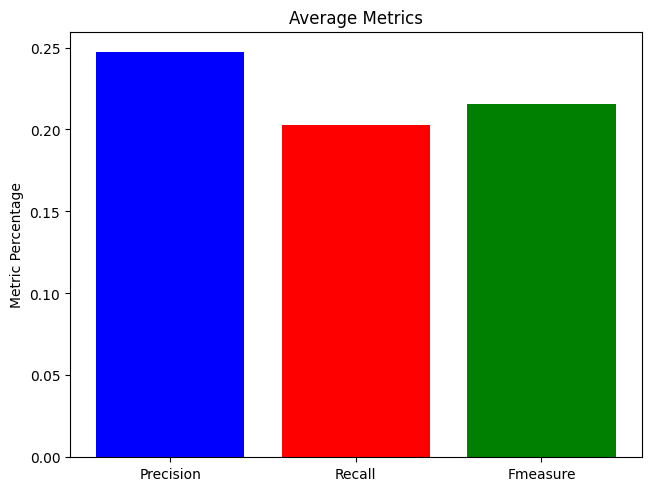

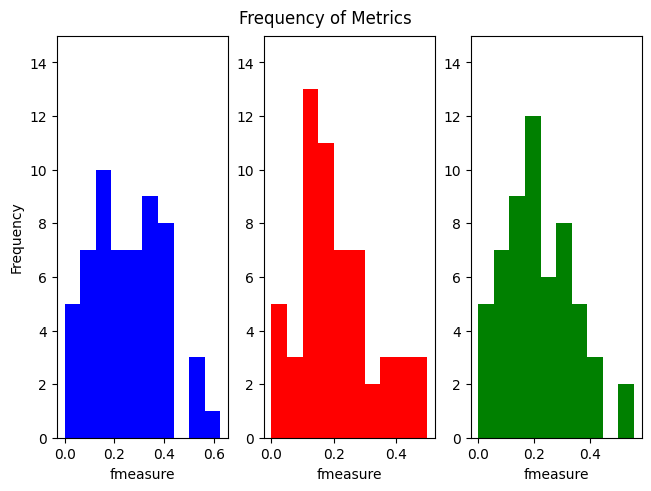

In [112]:
# Plot transformer rogue scores
# Plot average scores across all tested samples
fig_avg, ax_avg = plt.subplots(layout='constrained')
ax_avg.bar(avg_metrics['tf'].keys(), avg_metrics['tf'].values(), color=['blue', 'red', 'green'])
ax_avg.set_ylabel('Metric Score')
ax_avg.set_title('TF: Average Metrics')

# Plot frequency of specific scores across all tested samples
colors = ['blue', 'red', 'green']
fig_hist, ax_hist = plt.subplots(1, 3, layout='constrained')
for idx, key in enumerate(metrics['tf'].keys()):
    count, bin = np.histogram(metrics['tf'][key])
    ax_hist[idx].hist(bin[:-1], bin, weights=count, label=key, color=colors[idx])
    ax_hist[idx].set_xlabel(list(metrics['tf'].keys())[i])
    ax_hist[idx].set_ylim(0, 15)
ax_hist[0].set_ylabel('Frequency')
fig_hist.suptitle('TF: Frequency of Metrics')

In [ ]:
# Plot encoder decoder rogue scores
# Plot average scores across all tested samples
fig_avg, ax_avg = plt.subplots(layout='constrained')
ax_avg.bar(avg_metrics['ed'].keys(), avg_metrics['ed'].values(), color=['blue', 'red', 'green'])
ax_avg.set_ylabel('Metric Percentage')
ax_avg.set_title('ED: Average Metrics')

# Plot frequency of specific scores across all tested samples
colors = ['blue', 'red', 'green']
fig_hist, ax_hist = plt.subplots(1, 3, layout='constrained')
for idx, key in enumerate(metrics['ed'].keys()):
    count, bin = np.histogram(metrics['ed'][key])
    ax_hist[idx].hist(bin[:-1], bin, weights=count, label=key, color=colors[idx])
    ax_hist[idx].set_xlabel(list(metrics['ed'].keys())[i])
    ax_hist[idx].set_ylim(0, 15)
ax_hist[0].set_ylabel('Frequency')
fig_hist.suptitle('ED: Frequency of Metrics')